## Mini-Project - Image classification

Let's get all the required libraries and visually see the dataset :

In [ ]:
!pip install -U pandas
!pip install tensorflow
!pip install seaborn
!pip install keras

import pickle

In [2]:
# using gpu acceleration
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
import sys
sys.version

Num GPUs Available:  1
2.6.0


'3.9.15 (main, Nov 24 2022, 14:39:17) [MSC v.1916 64 bit (AMD64)]'

In [ ]:
!pip install -U scikit-learn

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten 
from tensorflow.keras.layers import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical

### Importing the dataset :

In [5]:
df = pd.read_pickle('train100c5k_v2.pkl')
train_data = np.array([x.reshape(28 * 28, ) for x in df['data']])

df_test = pd.read_pickle('test100c5k_nolabel.pkl')
test_data = np.array([x.reshape(28 * 28, ) for x in df_test['data']])

In [6]:
df.head()

,data,target
0,"[[46, 132, 11, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0
1,"[[0, 0, 3, 0, 116, 78, 0, 1, 1, 0, 0, 0, 0, 0,...",0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,...",0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
4,"[[0, 0, 0, 69, 165, 202, 199, 214, 204, 170, 1...",0


In [7]:
# Seeing the train_data after reshaping into 28 * 28 :
np.info(train_data)

class:  ndarray
shape:  (500000, 784)
strides:  (784, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x2022843c040
byteorder:  little
byteswap:  False
type: uint8


0
()


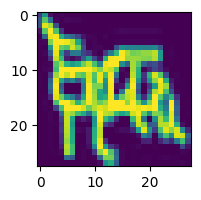



0
()


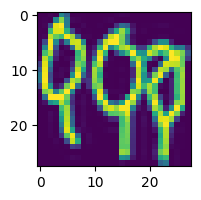



0
()


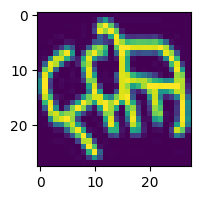



0
()


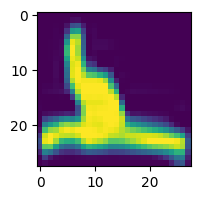



0
()


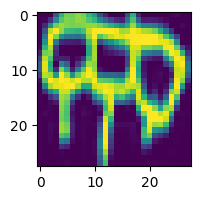

In [8]:
# Let's visualise the data :
for i in range(5):
    plt.figure(figsize=(2,2))
    plt.imshow(df.data.values[i])
    print(df.target.values[i])
    print(df.target.values[i].shape)
    plt.show()
    print('\n')

In [9]:
df['target'].value_counts(dropna=False)

0     5000
63    5000
73    5000
72    5000
71    5000
      ... 
30    5000
29    5000
28    5000
27    5000
99    5000
Name: target, Length: 100, dtype: int64

In [10]:
df['target'].value_counts(dropna=False).index

Int64Index([ 0, 63, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 62,  1, 61, 60, 59,
            58, 57, 56, 55, 54, 53, 52, 74, 75, 76, 77, 98, 97, 96, 95, 94, 93,
            92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 51, 50,
            49, 24, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,
             7,  6,  5,  4,  3,  2, 23, 25, 48, 26, 47, 46, 45, 44, 43, 42, 41,
            40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 99],
           dtype='int64')

## Inferences from the data set :
- We see that the dataset contains 100 classes containing 5000 images each
- The best way to classify such a large image set is by using a CNN.
- A CNN will take the input as the image (28,28,1 - the last dimension signifies that there is only value from rgb, i.e a single image signal, essentially a gray-scale image). 
- Based on the kernel size (which we will use 3,3) it will provide a convolved featureset, which would preserve only the high-level features of the image.


In [11]:
# Getting the data ready into the training set :
X_main = train_data
X_main = X_main.reshape(-1,28,28,1)

# We need to encode the 'target' values : (Essentially one hot encoding the classes)

y_check = df['target']
y_check = to_categorical(y_check)

# We should get 100 classes after encoding :
print(y_check.shape)

(500000, 100)


In [12]:
# Since we only have the training set, we need to divide it into validation set to check the model accuracy :

X_train, X_test, y_train, y_test = train_test_split(X_main, y_check, test_size=0.1, random_state=0)

In [13]:
X_train.shape, X_test.shape

((450000, 28, 28, 1), (50000, 28, 28, 1))

In [14]:
 y_train.shape, y_test.shape

((450000, 100), (50000, 100))

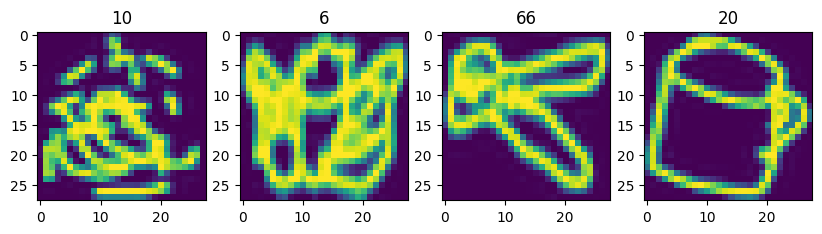

In [15]:
X_train_check= X_train.reshape(X_train.shape[0], 28, 28)

# Let's plot the classes with the images :

fig, axis = plt.subplots(1, 4, figsize=(10,8))

for i, ax in enumerate(axis.flat):
    ax.imshow(X_train_check[i])
    number = y_train[i].argmax()
    ax.set(title = number);

In [16]:
# Normalising the dataset is the best way to preserve the inherent covariance in the image set :

calc_mean = np.mean(X_train)
calc_std = np.std(X_train)

def normalise(x):
    return (x-calc_mean)/calc_std

## Model Assumptions :

Let's now build the CNN architecture.

We will build a network with:

- 3 convolutional layers with 64,128,256 filters respectively,
- Then adding a max pooling layer
- Flattenning the output of the pooling layer to give the vector
- Adding a fully connected Dense layer with 512 neurons
- Softmax layer with 100 neurons

The generic way to build a model in Keras is to instantiate a Sequential model and keep adding keras.layers to it.

In [17]:
# Implemnting model parameters to check the best possible model :

# Sequential model is by far the most implemented model utilised for CNN.
model=Sequential()

# Adding the normalising function into the CNN :
model.add(Lambda(normalise,input_shape=(28,28,1)))

# Model parameter tuning  :
## We are using relu activation rather than softmax or sigmoid. It is also the most implemented activation functions in practice :

model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

### some of the parameters are greyed out based on the results obtained.
# model.add(Dropout(0.25))

# using normalisation for the layers of CNN :
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2)))### some of the parameters are greyed out based on the results obtained.
### some of the parameters are greyed out based on the results obtained.
# model.add(Dropout(0.4))

model.add(BatchNormalization())    

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.3))
model.add(BatchNormalization())
    
model.add(Flatten())
model.add(Dense(512,activation="relu"))
# model.add(Dropout(0.3))

# The final softmax function will transform the raw outputs of the neural network into a vector of probabilities, further used for prediction :
model.add(Dense(100,activation="softmax"))

In [18]:
# Final Compilation of the model using loss parameters :
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [19]:
# Let's check the summary of the model after choosing all the hyperparameters of the CNN
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         1

In [20]:
# The best way to train a cnn is to use Data Augumentation, in which the image data is rotated zoomed, and shifted to augument to the image data.
# This helps the model better understand the image data.

## this has directly been taken from keras library and the parameters changed based on the findings :
## the changed paramters have been explained below :

Augumented_data = ImageDataGenerator(
    ## rotate images (degrees, 0 to 20)
        rotation_range=20,  
    ## zoom image 
        zoom_range = 0.01,
    ## shift images horizontally
        width_shift_range=0.1,
    ## shift images vertically
        height_shift_range=0.1) 

train_aug_image = Augumented_data.flow(X_train, y_train, batch_size=128)
test_aug_image = Augumented_data.flow(X_test, y_test, batch_size=128)

In [21]:
## batch size is a hyperparameter of gradient descent that controls the number of training samples to use before the model’s parameters are updated/ changed.
## number of epochs is a hyperparameter of gradient descent that controls the number of  passes through the training data.

num_epochs = 50
batch_size = 128

## As explained above, we are using batch_size to update the model parameters periodically :

train_steps = X_train.shape[0] // batch_size
valid_steps = X_test.shape[0] // batch_size

## Since epochs take really long to run, we will use methods to stop the model if there is not much change in the validation accuracy parameter:

early_stop = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
    ## Stopping by 5 epochs
        patience=5,
        verbose=1,
    ## We will set the paramters of epoch where the maximum validation accuracy was obtained 
        mode="max",
        restore_best_weights=True 
     )

## Similarly we use ReduceLROnPlateau as an early stopping way :

plateau_achieved = keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=5,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [22]:
# using time module to store the data to see how long the epochs are running : (## gpu vs cpu )

import time
start_time = time.time()

history = model.fit(train_aug_image, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = test_aug_image,
                    validation_steps = valid_steps, 
                    callbacks=[early_stop, plateau_achieved])

print(time.time()-start_time)

Epoch 1/50
3515/3515 [==============================] - 73s 20ms/step - loss: 1.8535 - accuracy: 0.5274 - val_loss: 1.6683 - val_accuracy: 0.5633
Epoch 2/50
3515/3515 [==============================] - 68s 19ms/step - loss: 1.3768 - accuracy: 0.6370 - val_loss: 1.3625 - val_accuracy: 0.6430
Epoch 3/50
3515/3515 [==============================] - 69s 20ms/step - loss: 1.2579 - accuracy: 0.6660 - val_loss: 1.2641 - val_accuracy: 0.6660
Epoch 4/50
3515/3515 [==============================] - 68s 19ms/step - loss: 1.1905 - accuracy: 0.6822 - val_loss: 1.2386 - val_accuracy: 0.6740
Epoch 5/50
3515/3515 [==============================] - 69s 19ms/step - loss: 1.1418 - accuracy: 0.6936 - val_loss: 1.1881 - val_accuracy: 0.6862
Epoch 6/50
3515/3515 [==============================] - 68s 19ms/step - loss: 1.1071 - accuracy: 0.7026 - val_loss: 1.1766 - val_accuracy: 0.6886
Epoch 7/50
3515/3515 [==============================] - 69s 20ms/step - loss: 1.0764 - accuracy: 0.7096 - val_loss: 1.1548 -

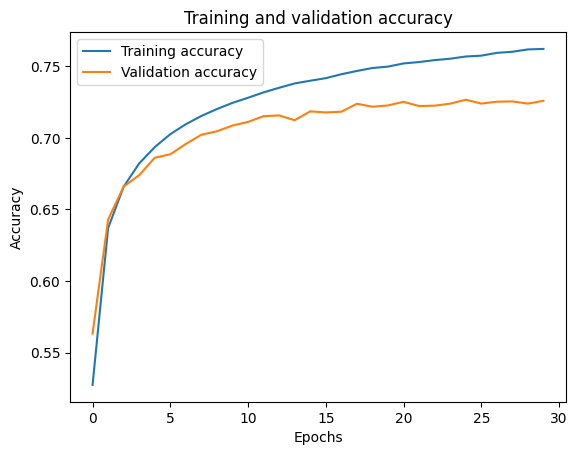

In [23]:
## plotting the training and validation accuracy :

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

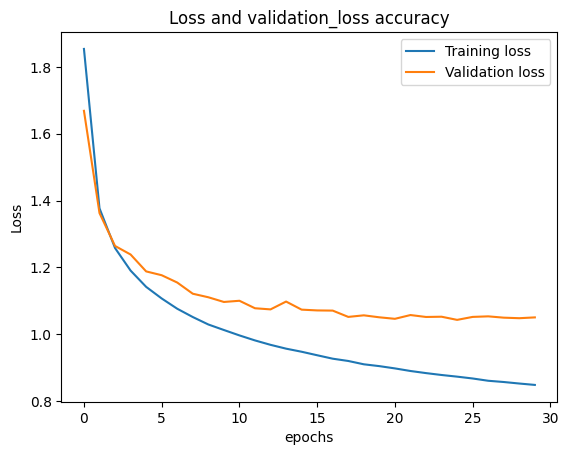

In [24]:
## Let's plot the loss and validation_loss curves :

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss and validation_loss accuracy')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

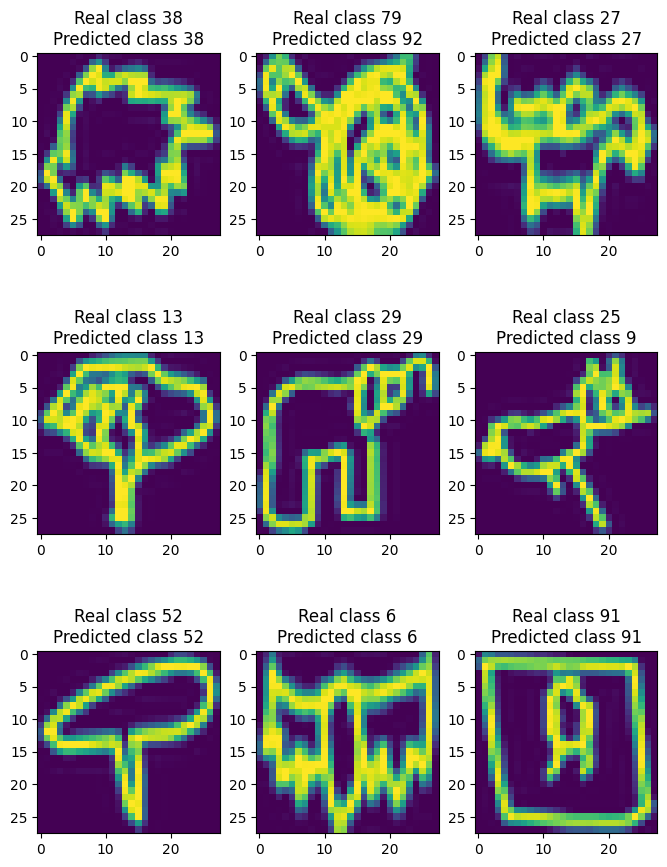

In [27]:
# Let's actually see how our model performed :

y_pred = model.predict(X_test)
X_test_check = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(3, 3, figsize=(8,11))

for i, ax in enumerate(axis.flat):
    ax.imshow(X_test_check[i])
    ax.set(title = f"Real class {y_test[i].argmax()}\nPredicted class {y_pred[i].argmax()}");

## Working on the test data :

In [49]:
df_test = pd.read_pickle('test100c5k_nolabel.pkl')
test_data = np.array([x.reshape(28 * 28, ) for x in df_test['data']])
test_data = test_data.reshape(-1,28,28,1)

# mean = np.mean(test_data)
# std = np.std(test_data)

# def norm(x):
#     return (x-mean)/std

# test_norm = norm(test_data)

# test_check = 

test_x = test_data.reshape(-1,28,28,1)

# predict test data
pred = model.predict(test_x, verbose=1)

3125/3125 [==============================] - 4s 1ms/step


In [50]:
pred

array([[2.0219987e-11, 1.0732527e-08, 4.7952592e-10, ..., 8.6995900e-13,
        3.5948942e-11, 5.6608673e-09],
       [1.7837937e-04, 2.6771287e-09, 1.6492179e-09, ..., 2.8890536e-11,
        4.4414181e-10, 7.2232616e-08],
       [4.9971213e-04, 8.8732259e-04, 1.0168694e-02, ..., 1.1743596e-03,
        3.7905443e-04, 2.4101785e-03],
       ...,
       [5.5803184e-08, 6.9251755e-08, 2.3382956e-08, ..., 2.2207631e-09,
        3.5593125e-08, 3.1658676e-09],
       [5.1650267e-02, 6.0395037e-06, 2.5054518e-05, ..., 8.1458575e-06,
        3.0085686e-04, 8.9486630e-04],
       [9.2083719e-05, 2.3279656e-06, 4.8006782e-06, ..., 1.1545100e-08,
        9.7358665e-05, 4.1051360e-04]], dtype=float32)

In [51]:
submission = [pred[i].argmax() for i in range(len(pred))]

In [52]:
len(submission)

100000

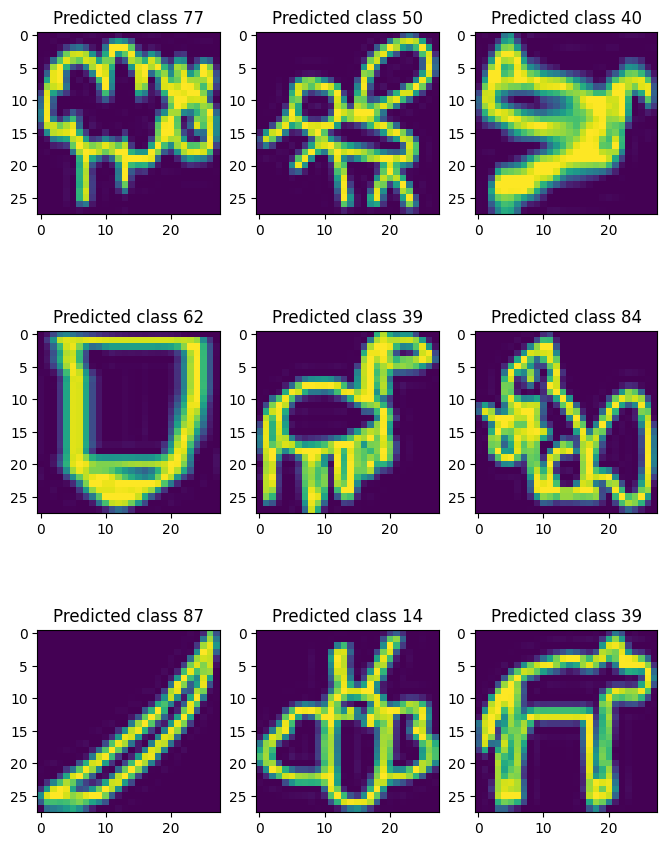

In [55]:
## Let's check submission's actual predicted values :

fig, axis = plt.subplots(3, 3, figsize=(8,11))

for i, ax in enumerate(axis.flat):
    ax.imshow(test_norm[i])
    ax.set(title = f"Predicted class {pred[i].argmax()}");

## Results of predictions :

In [76]:
# Let's visualise the data :
df = pd.read_pickle('train100c5k_v2.pkl')

77
()


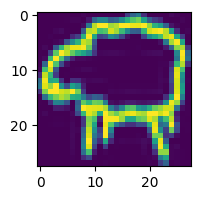



50
()


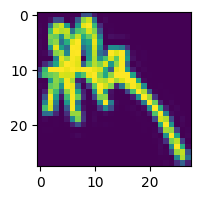



40
()


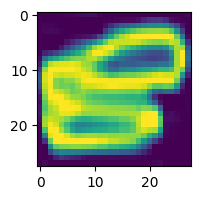



62
()


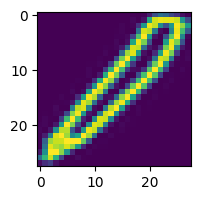



39
()


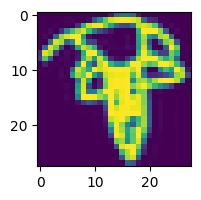



84
()


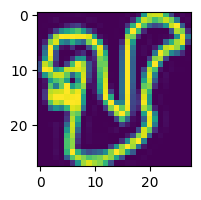



87
()


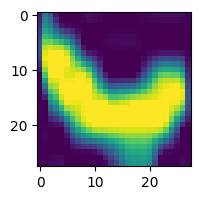



14
()


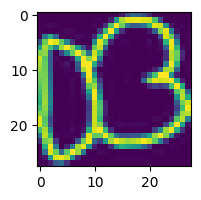



39
()


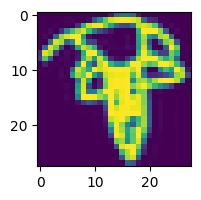

In [78]:
## finally checking the file for classifications :
to_check = [77,50, 40,62,39,84,87,14,39]

for val in to_check :
    df = pd.read_pickle('train100c5k_v2.pkl')
    df = df[df['target'] == val]
    
    for i in range(1):
        print(val)
        plt.figure(figsize=(2,2))
        plt.imshow(df.data.values[i])
        print(df.target.values[i].shape)
        plt.show()
        print('\n')

In [81]:
## saving the model and generating the txt file :

# model.save('model_shubpras', save_format='h5')
# print('done_model')

# with open('project_shubpras.txt', 'w') as file:
#     file.write('\n'.join(map(str, submission)))
#     file.flush()

# print('done_txt')


done_model
done_txt


## Now that we have seen the model run :

### Observations :

- We can clearly see that some of the ambiguous images have reduced the learning of our model.
- By increasing the number of layers and complexity, we can increase the validation accuracy only upto a certain point.


## How to make a better model :

- Using Kfold could have been a way of improving model accuracy.
- I also wanted to implement pca and check the accuracy of the model, however, that is for a later time

---
